# Exercise 1 - Mathematical Foundations of Computer Graphics and Vision
Andreas Voigt - FS2021

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import time

np.random.seed(int(time.time()))
# np.random.seed(42) # Make results reproducable for hand-in

## Part 1: RANSAC for Circle Fitting
### 1.1: Data generation

In [2]:
# Define constant parameters for this exercise
ground_truth_center = np.array([0,0])
ground_truth_radius = 5

n_points = 100
outlier_ratio = 0.2
noise_amplitude = 0.1
domain_size = 10

(-10.0, 10.0, -10.0, 10.0)

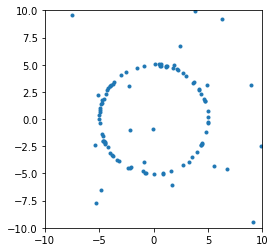

In [3]:
def generate_circle_data(center, radius, n_points, outlier_ratio, noise_amplitude, domain_size):
    n_inliers = int(n_points * (1-outlier_ratio))
    n_outliers = n_points - n_inliers

    # Generate inliers on circle
    angles = np.random.rand(n_inliers) * 2 * np.pi
    inliers = center + np.stack([np.cos(angles) * radius, np.sin(angles) * radius]).T # Generate points without noise

    for i in range(inliers.shape[0]):
        while True:
            noise = (np.random.rand(2) - 0.5) * 2 * noise_amplitude
            if np.linalg.norm(noise) <= noise_amplitude:
                inliers[i,:] += noise
                break

    outliers = (np.random.rand(n_outliers, 2) - 0.5) * 2 * domain_size
    data = np.vstack([inliers, outliers])
    return data

data = generate_circle_data(ground_truth_center, ground_truth_radius, n_points, outlier_ratio, noise_amplitude, domain_size)
plt.scatter(data[:,0], data[:,1], marker='.');
plt.axis("scaled");
plt.axis([-domain_size, domain_size, -domain_size, domain_size])

## Fitting and Inlier-Classification
We will now define a class representing a circle that will be used in the RANSAC step below. 

### Least-Squares Fitting
A circle is uniquely defined by 3 parameters: $x_{center}, y_{center}, r$. The circle equation is then given by:

$$
    \begin{align}
        (x-x_{center})^2 + (y-y_{center})^2 &= r^2 \\
        2x\underbrace{x_{center}}_{a} + 2y\underbrace{y_{center}}_{b} + \underbrace{r^2-x_{center}^2-y_{center}^2}_{c} &= x^2 + y^2 \\
        \left( \begin{matrix} 2x & 2y & 1 \end{matrix} \right) \left( \begin{matrix} a \\ b \\ c \end{matrix} \right) &= x^2 + y^2
    \end{align}
$$

For $n$ datapoints, the last equation can be stacked n times to get a matrix-vector equation that can be solved in the least-squares sense.

$$
    \left( \begin{matrix} 
        2x_1 & 2y_1 & 1  \\
        \vdots & \vdots & \vdots  \\
        2x_n & 2y_n & 1  \\
    \end{matrix} \right) 
    \left( \begin{matrix} a \\ b \\ c \end{matrix} \right) = 
    \left( \begin{matrix} 
        x_1^2 + y_1^2  \\
        \vdots \\
        x_n^2 + y_n^2 \\
    \end{matrix} \right)
$$

The center is then given by: $ x_{center} = a, y_{center} = b $ and the radius by $ r = \sqrt{c+a^2+b^2} $.

### Inlier-Classification
Next we need to define a function to classify inliers given a fitted circle. We therefore calculate the distance to the circle center for each given datapoint. All points that have a distance in the interval $[R-\tau, R+\tau]$ are classified as inliers, all others as outliers.

### Code

In [4]:
class Circle:
    sample_size = 3

    def __init__(self, center, radius):
        self.cx = center[0]
        self.cy = center[1]
        self.r = radius
    
    @classmethod    
    def fit(cls, data):
        """
        Fits a circle in the provided data and returns a new instance of Circle
        """

        # As explained above
        A = np.hstack([2*data, np.ones([data.shape[0], 1])])
        b = np.sum(data**2, axis=1)
        x = np.linalg.lstsq(A, b)[0]      
        cx = x[0]
        cy = x[1]
        r = np.sqrt(x[2] + cx**2 + cy**2)
        return cls((cx, cy), r)

    def get_inlier_mask(self, data, threshold):
        center_distances = np.linalg.norm(data-np.array([self.cx, self.cy]), axis=1)
        errors = np.abs(center_distances - self.r)
        return errors <= threshold

Now let us check if the class works:

Check fitting:
Fitted Circle: 		            x:-0.00024,             y:-0.00065,             r:+5.00636
Ground truth circle: 	            x:+0.00000,             y:+0.00000,             r:+5.00000
********************
Check inlier classification:
Estimated inliers: 	80,             Estimated outliers: 	20,             Estimated outlier ratio: 	0.2
Ground truth inliers: 	80,             Ground truth outliers: 	20,             Ground truth outlier ratio: 	0.2


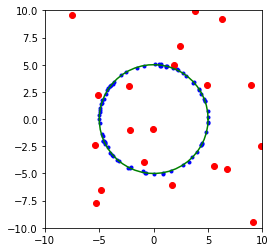

In [5]:
def check_fitting(fitted_circle, ground_truth_circle):
    print("Check fitting:")
    print(f"Fitted Circle: \t\t\
            x:{fitted_circle.cx:+.5f}, \
            y:{fitted_circle.cy:+.5f}, \
            r:{fitted_circle.r:+.5f}")
    print(f"Ground truth circle: \t\
            x:{ground_truth_circle.cx:+.5f}, \
            y:{ground_truth_circle.cy:+.5f}, \
            r:{ground_truth_circle.r:+.5f}")

def check_inlier_classification(inlier_mask):
    print("Check inlier classification:")
    print(f"Estimated inliers: \t{np.count_nonzero(inlier_mask)}, \
            Estimated outliers: \t{np.count_nonzero(~inlier_mask)}, \
            Estimated outlier ratio: \t{np.count_nonzero(~inlier_mask)/len(inlier_mask)}")
    print(f"Ground truth inliers: \t{int(n_points * (1-outlier_ratio))}, \
            Ground truth outliers: \t{n_points - int(n_points * (1-outlier_ratio))}, \
            Ground truth outlier ratio: \t{outlier_ratio}")

def plot_estimation(fitted_circle, inlier_mask):
    plt.scatter(data[inlier_mask,0], data[inlier_mask,1], c='b', marker='.')
    plt.scatter(data[~inlier_mask,0], data[~inlier_mask,1], c='r', marker='o')
    def get_circle_points(circle):
        angles = np.linspace(0, 2*np.pi)
        x = circle.cx + circle.r * np.cos(angles)
        y = circle.cy + circle.r * np.sin(angles)
        return x, y
    plt.plot(*get_circle_points(fitted_circle), 'g')
    plt.axis('scaled');\
    plt.axis([-domain_size, domain_size, -domain_size, domain_size])
    

fitted_circle = Circle.fit(data[:int(n_points*(1-outlier_ratio)),:]) # A bit hacky but we know that all inliers are in the first portion of data... ;)
ground_truth_circle = Circle(ground_truth_center, ground_truth_radius)
inlier_mask = ground_truth_circle.get_inlier_mask(data, noise_amplitude)

check_fitting(fitted_circle, ground_truth_circle)
print("*"*20)
check_inlier_classification(inlier_mask)
plot_estimation(fitted_circle, inlier_mask)



Most of the inliers and outliers are classified correctly. There are however some errors that lead to an outlier ratio that is slightly off:
* The noise with amplitude 0.1 is added on both coordinates (x, y) independently. However, we use the euclidian distance to classify inliers later on. Setting the same threshold of 0.1 on the distance results some incorrect classifications (e.g. when the noise is 0.1 on both x and y). This problem seems to be present in figure 1 from the handout as well. A solution would be to adapt the data generation reject all noisy inliers that have a magnitude of more than 0.1 (rejection sampling).
* There are cases when the generated outliers fall within the inlier range

## 1.2 RANSAC
In the next section we will implement the RANSAC algorithm for a generic model. It will then be applied to the circle model defined above.

In [6]:
def ransac(data, model, outlier_ratio, success_rate):
    # calculate the theoretical number of iterations
    n_iter = math.ceil(math.log(1-success_rate)/math.log(1-(1-outlier_ratio)**model.sample_size))

    best_inlier_mask = np.zeros(data.shape[0], dtype=bool)
    best_model = None
    for i in range(n_iter):
        indices = np.random.choice(data.shape[0], model.sample_size, replace=False)
        current_model = model.fit(data[indices,:])
        inlier_mask = current_model.get_inlier_mask(data, noise_amplitude)
        if np.count_nonzero(inlier_mask) > np.count_nonzero(best_inlier_mask):
            best_inlier_mask = inlier_mask
            best_model = current_model
    return best_model, best_inlier_mask    

Check fitting:
Fitted Circle: 		            x:-0.01805,             y:+0.01319,             r:+4.97457
Ground truth circle: 	            x:+0.00000,             y:+0.00000,             r:+5.00000
********************
Check inlier classification:
Estimated inliers: 	76,             Estimated outliers: 	24,             Estimated outlier ratio: 	0.24
Ground truth inliers: 	80,             Ground truth outliers: 	20,             Ground truth outlier ratio: 	0.2


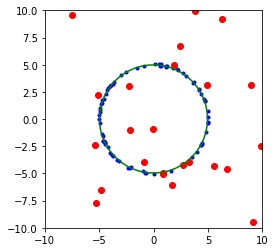

In [7]:
ransac_circle, ransac_inlier_mask = ransac(data, Circle, outlier_ratio, 0.99)
check_fitting(ransac_circle, ground_truth_circle)
print("*"*20)
check_inlier_classification(ransac_inlier_mask)
plot_estimation(ransac_circle, ransac_inlier_mask)

## 1.3 Exhaustive Search
Try all combinations of 3 data points and return the best one.

In [8]:
def exhaustive_search(data, threshold):
    combs = list(itertools.combinations(data, 3))

    n_inliers = np.zeros(len(combs))
    for i, sample in enumerate(combs):
        circle = Circle.fit(np.array(sample))
        inlier_mask = circle.get_inlier_mask(data, threshold)
        n_inliers[i] = np.count_nonzero(inlier_mask)
    return combs, n_inliers


In [9]:
combinations, n_inliers = exhaustive_search(data, noise_amplitude)

10.0


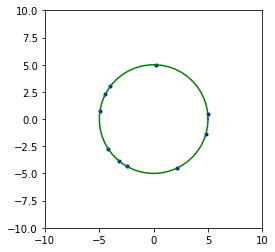

In [10]:
for i in range(10):
    noise_amplitude = 0.0
    data = generate_circle_data(ground_truth_center, ground_truth_radius, 10, 0.0, noise_amplitude, domain_size)

    combinations, n_inliers = exhaustive_search(data, noise_amplitude)
    print(np.max(n_inliers))
    circle = Circle.fit(np.array(combinations[np.argmax(n_inliers)]))
    inlier_mask = circle.get_inlier_mask(data, noise_amplitude+1e-10)
    #plt.scatter(data[:,0], data[:,1])
    plot_estimation(circle, inlier_mask)
    break

# print(np.max(n_inliers))
# plt.hist(n_inliers, 100, range=[0,100]);